# DES SN 5YR Tutorial Part 6: Demonstrate cosmology analysis using Des SN 5 year

<img align="left" src = ../_static/images/logo044.jpg width=120 style="padding: 10px"> 
<br><b>Dark Energy Survey Supernova Program</b>

<b>Tutorial</b>
<b>Cosmology analysis using DES SN 5 year</b> <br>
Contact author: Paul Shah<br>

Sheet to demonstrate cosmology analysis using Des SN 5 year

Results will not exactly match Key Paper due to settings, use of Astropy (instead of CAMB) etc.

To run this sheet you will need : 

- Polychord install (available from https://github.com/PolyChord/PolyChordLite)
- Getdist (available from https://github.com/cmbant/getdist/tree/master or package installers like pip or conda)
- standard libraries numpy, matplotlib, astropy, pandas (available from package installers)

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.cosmology import FlatwCDM, FlatLambdaCDM
import pandas as pd

import pypolychord
from pypolychord.settings import PolyChordSettings
from pypolychord.priors import UniformPrior

In [3]:
# setup MPI env for Polychord (you will need to have installed Polychord using MPI compilation option)
%env OMP_NUM_THREADS=8
%env OPENBLAS_NUM_THREADS=8
%env MKL_NUM_THREADS=8
%env VECLIB_MAXIMUM_THREADS=8
%env NUMEXPR_NUM_THREADS=8

mpl.rcParams['figure.figsize'] = (10, 10)

env: OMP_NUM_THREADS=8
env: OPENBLAS_NUM_THREADS=8
env: MKL_NUM_THREADS=8
env: VECLIB_MAXIMUM_THREADS=8
env: NUMEXPR_NUM_THREADS=8


In [4]:
import os
from dessndr import data, utils

You will need to download the Hubble diagram and covariance matrix from the GitHub repo, and unzip the cov. mat.
Then set the path to your downloaded data location. 

In [5]:
path = os.path.join(data.DES5YRDR_DATA, "4_DISTANCES_COVMAT/")

snfile = path + "DES-SN5YR_HD.csv"
covfile = path + "STAT+SYS.txt"

Note : zHD is the appropriate redshift to use in cosmological formulae, as it has been corrected for host peculiar velocities (eg see https://arxiv.org/pdf/1012.2912, Eqn 15)

In [6]:
(_, _, _, zhd, zhel, mu, muerr)  = np.genfromtxt(snfile, delimiter=',', dtype=np.float32, unpack=True, skip_header=1) 
nsn = len(zhd)

cov = np.genfromtxt(covfile)
cov = cov[1:]
cov = cov.reshape((nsn, nsn))

The covariance matrix is systematics only so add statistical error to the diagonal

    note : the statistical errors incorporate the probability of SN mis-classification (see https://arxiv.org/pdf/2401.02929.pdf) this down-weights likely contaminants (which mostly lie above the Hubble diagram) in the cosmology fit

In [7]:
np.fill_diagonal(cov, cov.diagonal() + muerr**2)
invcov = np.linalg.inv(cov)
invvars = 1/cov.diagonal()

print('Loaded ',nsn, ' sn')

Loaded  1829  sn


The DES-SN5YR sample is uncalibrated and doesn't measure H0 the relevant combination is 
    
    'script M' = M + 5 log10(c/H0)

Here, for pedagogical purposes, H0 and M are individual parameters, which allows this likelihood to be combined with SN calibrators such as the CMB or M-priors (eg SH0ES)

For the likelihood analytically marginalised over M, see `5_COSMOLOGY/SN_only_cosmosis_likelihood.py`

In [8]:
nDims = 3
nDerived = 1 # as an example usage, derived variable is q0 acceleration parameter in Flat wCDM

SN Ia on their own don't constrain H0 unless you have calibrated their absolute luminosity M 

Here we marginalise over 'script M' which is a (degenerate) combination of M and H0

See equations A9 - A12 of Goliath++ at https://arxiv.org/abs/astro-ph/0104009

`h0ref` is just set for convenience

In [9]:
h0ref = 70

def likelihood(theta):

    cosmo = FlatwCDM(H0=h0ref, Om0=theta[0], w0 =theta[1])
    scriptM = theta[2]
    ld = cosmo.luminosity_distance(zhd).value*(1+zhel)/(1+zhd)  #don't use astropy distmod, this formula correctly adjusts for peculiar velocities
    distmod = 5*np.log10(ld)+25
    residual = mu + scriptM - distmod
    residualT = np.transpose(residual)
    
    chit2 = np.sum(residual @ invcov @ residualT)
    B = np.sum(residual @ invcov)
    C = np.sum(invcov)
    chi2 = chit2 - (B**2 / C) + np.log(C / (2* np.pi))
    
    q0 = 0.5*(theta[0]+(1+3*theta[1])*(1-theta[0]))
    
    return -0.5*chi2, [q0]

Uses flat priors for parameters between ranges as below.

Other prior forms are available, see https://github.com/PolyChord/PolyChordLite

In [10]:
def prior(hypercube):
    """ Uniform prior from [-1,1]^D. """
    mins = np.array((0.1,-1.5,-1), dtype=float)
    maxs = np.array((0.5,-0.5,1), dtype=float)
    return UniformPrior(mins, maxs)(hypercube)

In [11]:
def dumper(live, dead, logweights, logZ, logZerr):
    print("Last dead point:", dead[-1])

In [12]:
# Main Polychord settings : uses recommended values
# for a quick run use nlive = 5*nDims, precision_criterion = 0.1
# seed is set for replicability of run

settings = PolyChordSettings(nDims, nDerived)
settings.file_root = 'dessn_fwcdm'
settings.nlive = 25*nDims
settings.num_repeats = 2*nDims
settings.nprior = 10*settings.nlive
settings.feedback = 1
settings.precision_criterion = 0.01
settings.seed = 1234 

# Secondary ones : 
settings.compression_factor = 0.36787944117144233
settings.logzero = -1.0e+30
settings.boost_posterior = 0
settings.posteriors = True
settings.equals = True
settings.cluster_posteriors = False
settings.write_stats = True
settings.write_dead = True
settings.write_live = True
settings.write_paramnames = True
settings.write_prior= True
settings.do_clustering = False
settings.read_resume = False
settings.write_resume = False

In [13]:
output = pypolychord.run_polychord(likelihood, nDims, nDerived, settings, prior, dumper)
output


PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.22.1
  release: 10th Jan 2024
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :      75
nDims    :       3
nDerived :       1
Synchronous parallelisation
Generating equally weighted posteriors
Generating weighted posteriors

generating live points


all live points generated

Speed  1 =  0.154E+00 seconds
number of repeats:            6
started sampling

Last dead point: [ 1.98631142e-01 -6.43021234e-01 -7.76498634e-01 -2.72945787e-01
 -1.00000000e+30 -8.25934729e+02]
_______________
lives      |75 |
phantoms   | 5 |
posteriors | 0 |
equals     | 0 |
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
ncluster   =       1 /       1
ndead      =                 676
nposterior =                 676
nequals    =                  19
nlike      =                 778
<nlike>    =           0.37   (           0.06 per slice )
log(Z)     =         -829.63 +/-  0.15
log(Z_1)   =         -829.63 +/-  0.15 (still e

Global evidence:
log(Z)    -826.937678 +/-  0.113245

Local evidences:
log(Z_1)    -826.937678 +/-  0.113245

Run-time information:
ncluster          1
nposterior     1160
nequals         182
ndead          1160
nlive             0
nlike          9768
<nlike>       [0.0]

Parameter estimates:
p0     2.605E-01 +/- 7.200E-02
p1    -8.109E-01 +/- 1.301E-01
p2    -4.594E-02 +/- 5.692E-01
p3    -3.862E-01 +/- 6.477E-02

 ____________________________________________________ 
|                                                    |
| ndead  =         1160                              |
| log(Z) =         -826.93768 +/-            0.11324 |
|____________________________________________________|


chains/dessn_fwcdm.txt
Removed no burn in


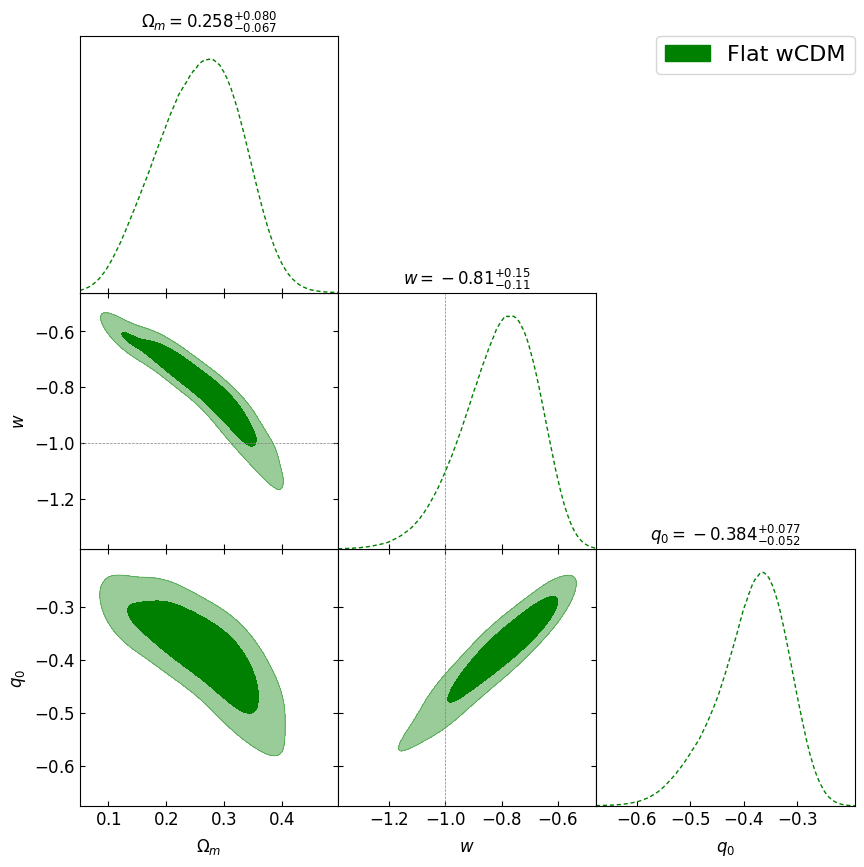

In [14]:
paramnames = [('Omega_m','\Omega_m'), ('w','w'), ('M','M') ,('q0','q_0')]
output.make_paramnames_files(paramnames)
try:
    import getdist.plots
    %matplotlib inline
    posterior = output.posterior
    g = getdist.plots.getSubplotPlotter(width_inch=10, scaling=False, rc_sizes=True)
    g.settings.legend_fontsize = 16
    g.settings.axes_fontsize=12
    g.settings.axes_labelsize =12
    
    g.triangle_plot(posterior, ['Omega_m', 'w','q0'],
    filled=True, 
    legend_labels=['Flat wCDM'], 
    legend_loc='upper right', 
    line_args=[{'ls':'--', 'color':'green'},
               {'lw':2, 'color':'darkblue'}], 
    contour_colors=['green','darkblue'],
    title_limit=1, # first title limit (for 1D plots) is 68% by default
    markers={'w':-1})
except ImportError:
    print("Install matplotlib and getdist for plotting examples")